# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-besra'
epochs = 10
batch_size = 8
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctor-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [10]:
get_dataloaders(X_train, y_train, X_val, y_val)

(<torch.utils.data.dataloader.DataLoader at 0x7a02220a7070>,
 <torch.utils.data.dataloader.DataLoader at 0x7a02220a4820>)

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    # class_probs = labeled_dataset.get_per_class_probs() 
    # label_probs = labeled_dataset.get_global_probs() 
    
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        # all_probs = []
        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))

    # Perform K-means clustering
    collected_indices = set()  # Initialize set to store selected indices
    
    accelerator.wait_for_everyone()
    
    if accelerator.is_local_main_process:
        num_of_candidates = len(score_changes[:math.ceil(0.1 * len(score_changes))])
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size

        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(score_changes)

        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
            
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    '1-FR': [y_train[i][0] for i in temp],
                    '2-GI': [y_train[i][1] for i in temp],
                    '3-PI': [y_train[i][2] for i in temp],
                    '4-DM': [y_train[i][3] for i in temp],
                    '5-EDTRB': [y_train[i][4] for i in temp],
                    '6-RE': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 7, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6831, Accuracy: 0.9048, F1 Micro: 0.9315, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5382, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4056, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3446, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2003, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1778

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7322, Accuracy: 0.7842, F1 Micro: 0.8247, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4072, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3384, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3043, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2231, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2092, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1837

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6606, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4941, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2728, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2492, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2031, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1682

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5893, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2403, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1748, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1734,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6374, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2484, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.181, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5696, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2281, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1624, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1794,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5114, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2063, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1795, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1503, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1378,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5412, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1844, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1488, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4847, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.214, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1509, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.14, Accuracy: 0.9673, F1 Micro: 0.9751,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5086, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.229, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1326,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2421, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2331, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1428, Accuracy: 0.9643, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4756, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2638, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2328, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2303, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1787, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1539, Accuracy: 0.9613, F1 Micro: 0.9704, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1312, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1898, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1179, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 9/10, Train Loss: 0.1377, Accuracy: 0.9554, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2017, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1314, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 9/10, Train Loss: 0.1519, Accuracy: 0.9554, F1 Micro: 0.965

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4404, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.193, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.12, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.1411, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Epoch 10/10, Train Loss: 0.1164, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4324, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1888, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1496, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Epoch 8/10, Train Loss: 0.1168, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0984, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4551, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1983, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1595, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1353, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1301, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.1045, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1951, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9568, F1 Micro: 0.9667, F1 Macro: 0.6478
Epoch 8/10, Train Loss: 0.1195, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6476
Epoch 9/10, Train Loss: 0.098, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6508
Epoch 10/10, Train Loss: 0.0875, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4047, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1688, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1567, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1563, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1712, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1722, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1403, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.385, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2069, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1597, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1535, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1159, Accuracy: 0.9702, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1496, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.13, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1219, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2019, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1712, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1462, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.1323, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7544
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1571, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.1318, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1181, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7118
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.131, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7244
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.746
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1762, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1619, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1401, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7963
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1757, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7561
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2124, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1552, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7532
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4133, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2197, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1676, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.1282, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.1044, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7939
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2113, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2035, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.757
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7933
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2073, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.177, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.1116, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.7302
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7393
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2101, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2038, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1284, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.9762, F1 Micro: 0.9818, F1 Macro: 0.7995
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3644, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.209, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1865, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1339, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0641, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2006, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1958, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1733, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1426, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.09

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1905, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.169, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9658, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2054, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1664, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1239, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0774, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.377, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1711, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8005
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9717, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2052, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1729, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9658, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1795, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.385, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.1102, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7595
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3505, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1647, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1326, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7811
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2043, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8005
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7652
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2095, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1575, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.761
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.323, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2041, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7902
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3455, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1266, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7987
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2077, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1464, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7901
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.333, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.206, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1996, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9539, F1 Micro: 0.9641, F1 Macro: 0.7108
Epoch 7/10, Train Loss: 0.1267, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7577
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2126, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1593, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7356
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7402
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1621, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.1395, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7846
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3393, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1638, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.731
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3296, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2039, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7329
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7402
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7818
Epoch 10/10, Train Loss: 0.066, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1934, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1616, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7528
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7346
Epoch 10/10, Train Loss: 0.0616, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3193, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1461, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3324, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1914, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7827
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.8023
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7567
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3484, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7751
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7478
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9583, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3308, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7534
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1926, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7902
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1906, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7688
Epoch 10/10, Train Loss: 0.0445, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3265, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1647, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0591, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7687
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3075, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7317
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7393
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3105, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1735, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7595
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3234, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7688
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.296, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1711, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7486
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7944
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0562, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3263, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7885
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.7912
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9762, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7402
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9732, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3068, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7384
Epoch 10/10, Train Loss: 0.0484, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3272, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1761, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0451, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2969, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1733, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7532
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Epoch 10/10, Train Loss: 0.0459, Accuracy:

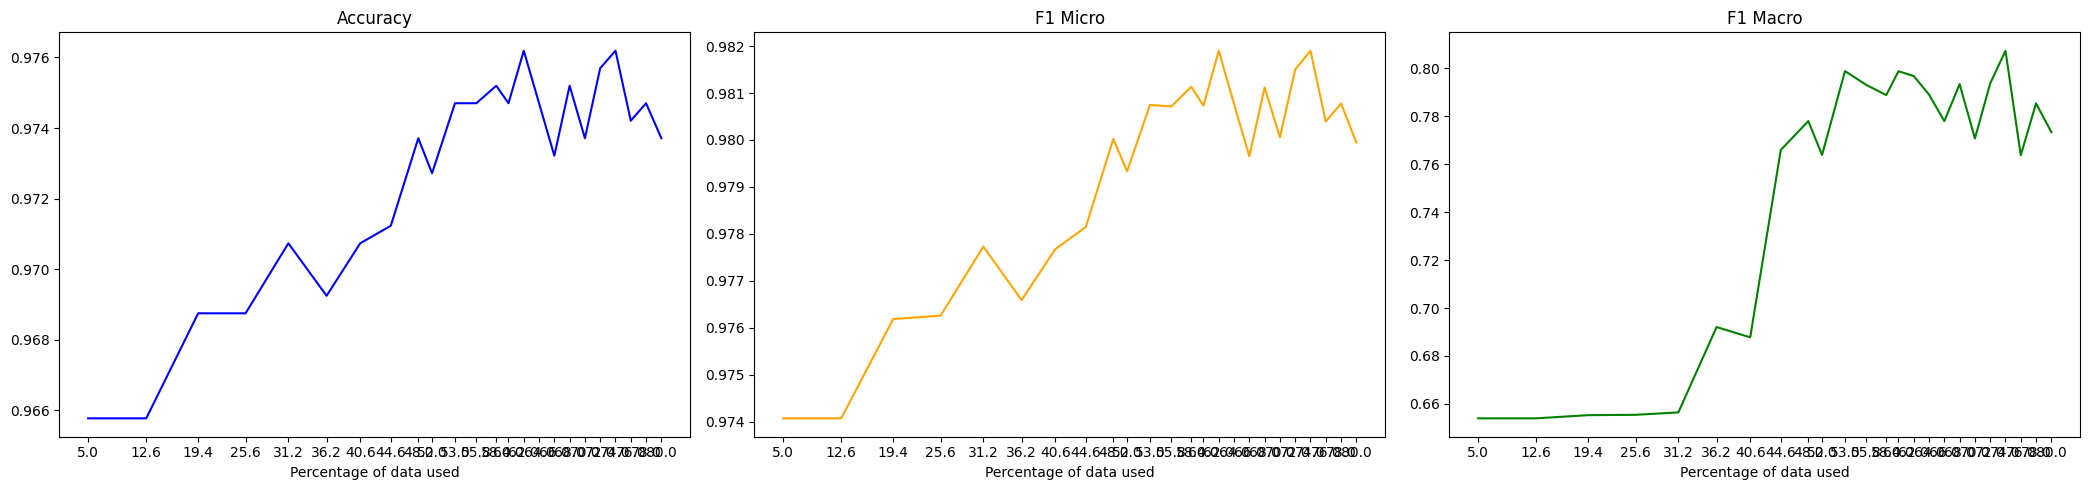

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.729, Accuracy: 0.8631, F1 Micro: 0.9017, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5287, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3941, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3215, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2603, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2039, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1971, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1658,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6703, Accuracy: 0.9524, F1 Micro: 0.9636, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3514, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2824, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2493, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2304, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1638

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6306, Accuracy: 0.881, F1 Micro: 0.9154, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.489, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.367, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2459, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1973, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1738, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2698, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1855, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1482, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1487, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1374, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3288, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1412, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1439, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1341, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3421, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1889, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1361,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1281, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1335, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.141, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1268, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1452, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.13, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1359, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1262, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1254, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4499, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1349, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1225, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1177

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1459, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1297, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1262,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4516, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1349, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1262, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1233

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4204, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1349, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.161, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 8/10, Train Loss: 0.1183, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1189, Accuracy: 0.9717, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1349, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1294, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4242, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1348, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1139, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9524, F1 Micro: 0.963, F1 Macro: 0.6446
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1396, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1282, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 9/10, Train Loss: 0.0995, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1629, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1368, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0982, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1046, Accuracy: 0.9702, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2148, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.108, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1971, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1627, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1464, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0925, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1682, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1434, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.075, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3652, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1959, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.168, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1474, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.097, Accuracy: 0.9673, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9568, F1 Micro: 0.9665, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7469
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7116
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.7146
Epoch 10/10, Train Loss: 0.0571, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2099, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7293
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7099
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7069
Epoch 10/10, Train Loss: 0.0589, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1883, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.1728, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 8/10, Train Loss: 0.1128, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 6/10, Train Loss: 0.1642, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0741, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1762, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Epoch 8/10, Train Loss: 0.1351, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.6511
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3572, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1313, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9747, F1 Micro: 0.980

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2017, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7124
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7117
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3368, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7972
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1853, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.767
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3459, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1904, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7217
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0563, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 5/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7402
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3222, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1898, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7469
Epoch 10/10, Train Loss: 0.0597, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7983
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3179, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1261, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7679
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3246, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.195, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1341, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0907, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3462, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7548
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7665
Epoch 10/10, Train Loss: 0.0573, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3232, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1812, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.741
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3218, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3527, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2073, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.6511
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0878, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0548, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1327, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0922, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7634
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1962, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Epoch 10/10, Train Loss: 0.0496, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3074, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1927, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3081, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1962, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9628, F1 Micro: 0.9715, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.797
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.33, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7762
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2027, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1411, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7679
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3064, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3457, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7827
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7892
Epoch 10/10, Train Loss: 0.0505, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3214, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1801, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.17, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9747, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8004
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0553, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3051, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1917, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7963
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.7912
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.317, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.8041
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2922, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7679
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0371, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2987, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.196, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9613, F1 Micro: 0.9702, F1 Macro: 0.7162
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.7432
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7402
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.286, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1812, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.791
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2899, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7811
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3008, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1472, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1459, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7373
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2858, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.7097
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3075, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.186, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2843, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9762, F1 Micro: 0

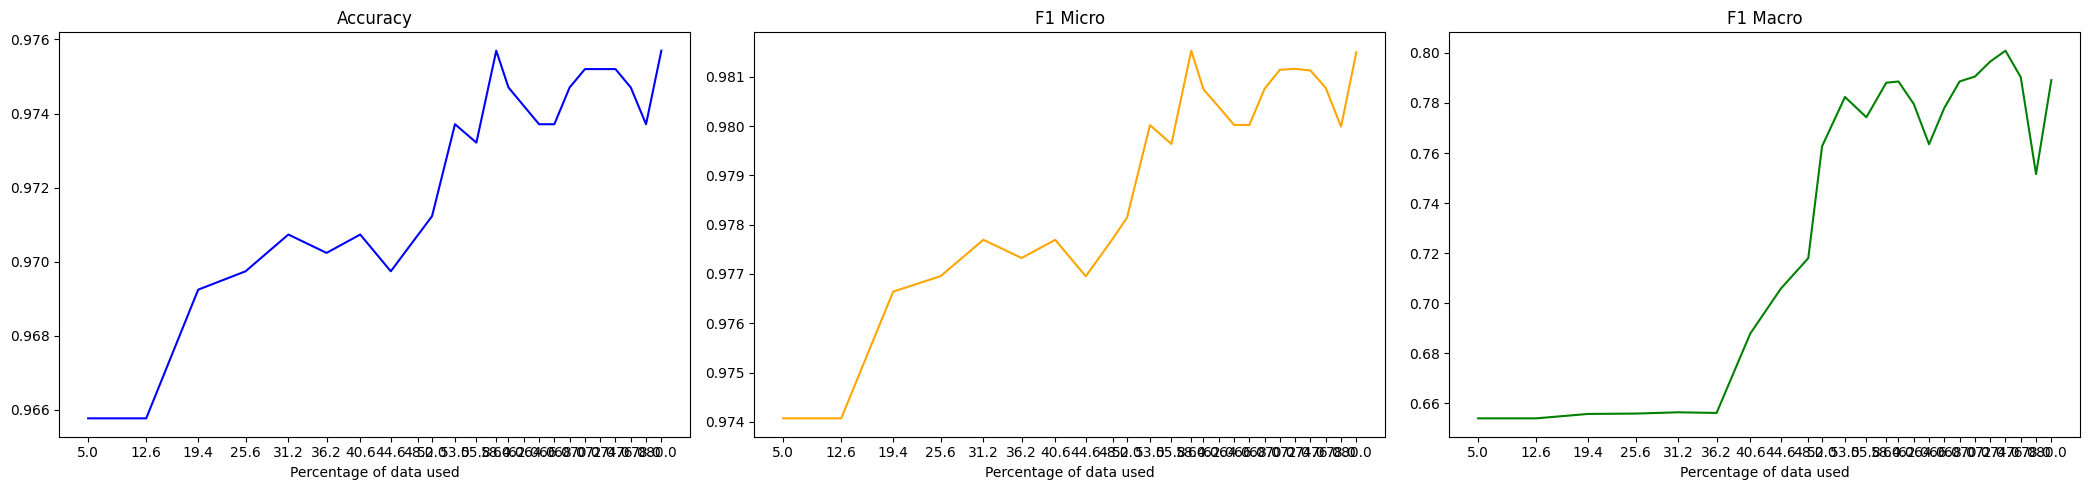

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 7, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6307, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3058, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2507, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.236, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1493, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1666,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.745, Accuracy: 0.8318, F1 Micro: 0.8546, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.52, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2775, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2458, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1904, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1544, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1725, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6258, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4344, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.293, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2233, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1451, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1698, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5574, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3329, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2001, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1527, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1367, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1429,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6424, Accuracy: 0.9226, F1 Micro: 0.9378, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3664, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1531, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1394, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5428, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3195, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2007, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1552, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1457, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1318, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1477, Accuracy: 0.9673, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5306, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1411, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1634, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1759, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1653, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4474, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1997, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1513, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1439, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1539,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5123, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2033, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1643,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4351, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2081, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2036, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1839, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1492, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1707,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1283, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1307, Accuracy: 0.9658, F1 Micro: 0.973

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1376, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.14, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1779, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1472, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1517, Accuracy: 0.9658, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2089, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1599, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1546, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1446, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1091, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4432, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1555, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1427, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1132

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2071, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1627, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1574, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.1318, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6526
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2035, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1698, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1641, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1198, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.0972, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 10/10, Train Loss: 0.0936, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4275, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1439, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.094

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2023, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1514, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1155, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1942, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1832, Accuracy: 0.9628, F1 Micro: 0.9715, F1 Macro: 0.6517
Epoch 7/10, Train Loss: 0.1476, Accuracy: 0.9494, F1 Micro: 0.9606, F1 Macro: 0.6426
Epoch 8/10, Train Loss: 0.1318, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.6536
Epoch 9/10, Train Loss: 0.1248, Accuracy: 0.9524, F1 Micro: 0.963, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0733, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.414, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1977, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1824, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.143, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1306, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1033,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.36, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2131, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2058, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1473, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1476, Accuracy: 0.9643, F1 Micro: 0.9725,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3457, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1786, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.138, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1741, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1738, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7586
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1784, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1934, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1512, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1358, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1053, Accuracy: 0.9747, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7375
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9658, F1 Micro: 0.9743, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.1086, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0885, Accuracy: 0.9747, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3455, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1353, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.1367, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7152
Epoch 9/10, Train Loss: 0.1116, Accuracy: 0.9524, F1 Micro: 0.963, F1 Macro: 0.7842
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3546, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.1404, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7012
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7643
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9702, F1 Micro: 0.9776, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9658, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.336, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2105, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1564, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0899, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7933
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1728, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9598, F1 Micro: 0.9696, F1 Macro: 0.6847
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7211
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7976
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9598, F1 Micro: 0.9691, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9613, F1 Micro: 0.9708, F1 Macro: 0.7376
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1969, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1795, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1734, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1266, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.745
Epoch 8/10, Train Loss: 0.1111, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7924
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7924
Epoch 10/10, Train Loss: 0.0703, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3374, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7027
Epoch 8/10, Train Loss: 0.1058, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7805
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3677, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1879, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7499
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.793
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 10/10, Train Loss: 0.0575, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3279, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1626, Accuracy: 0.9628, F1 Micro: 0.9717, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1218, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7953
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.9747, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3351, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2024, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1527, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6568
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7793
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2027, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1732, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7998
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7894
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2035, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1439, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9554, F1 Micro: 0.9654, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9762, F1 Micro: 0.9818, F1 Macro: 0.7996
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3239, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9777, F1 Micro: 0.9831, F1 Macro: 0.8006
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0656, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1814, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1403, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7924
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2045, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1527, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9524, F1 Micro: 0.963, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7998
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7876
Epoch 10/10, Train Loss: 0.0601, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2055, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1368, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3219, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7812
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1976, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7998
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7885
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1327, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7935
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7469
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3435, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9732, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3112, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0559, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3243, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.8227
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1861, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7448
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.7383
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7384
Epoch 10/10, Train Loss: 0.0607, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1273, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.6925
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1735, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9673, F1 Micro: 0.9754, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.8226
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7602
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2932, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1741, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9554, F1 Micro: 0.9653, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7969
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2961, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.32, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7438
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.292, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9598, F1 Micro: 0.9695, F1 Macro: 0.7364
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2939, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1839, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7402
Epoch 10/10, Train Loss: 0.0465, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2828, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7805
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7558
Epoch 10/10, Train Loss: 0.055, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1499, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7827
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9702, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3127, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9583, F1 Micro: 0.9689, F1 Macro: 0.7256
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9598, F1 Micro: 0.9696, F1 Macro: 0.7366
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7401
Epoch 10/10, Train Loss: 0.0504, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9717, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2855, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7657
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7894
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3101, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9598, F1 Micro: 0.97, F1 Macro: 0.7331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.752
Epoch 10/10, Train Loss: 0.0578, Accuracy: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.6567
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9613, F1 Micro: 0.9702, F1 Macro: 0.7603
Epoch 10/10

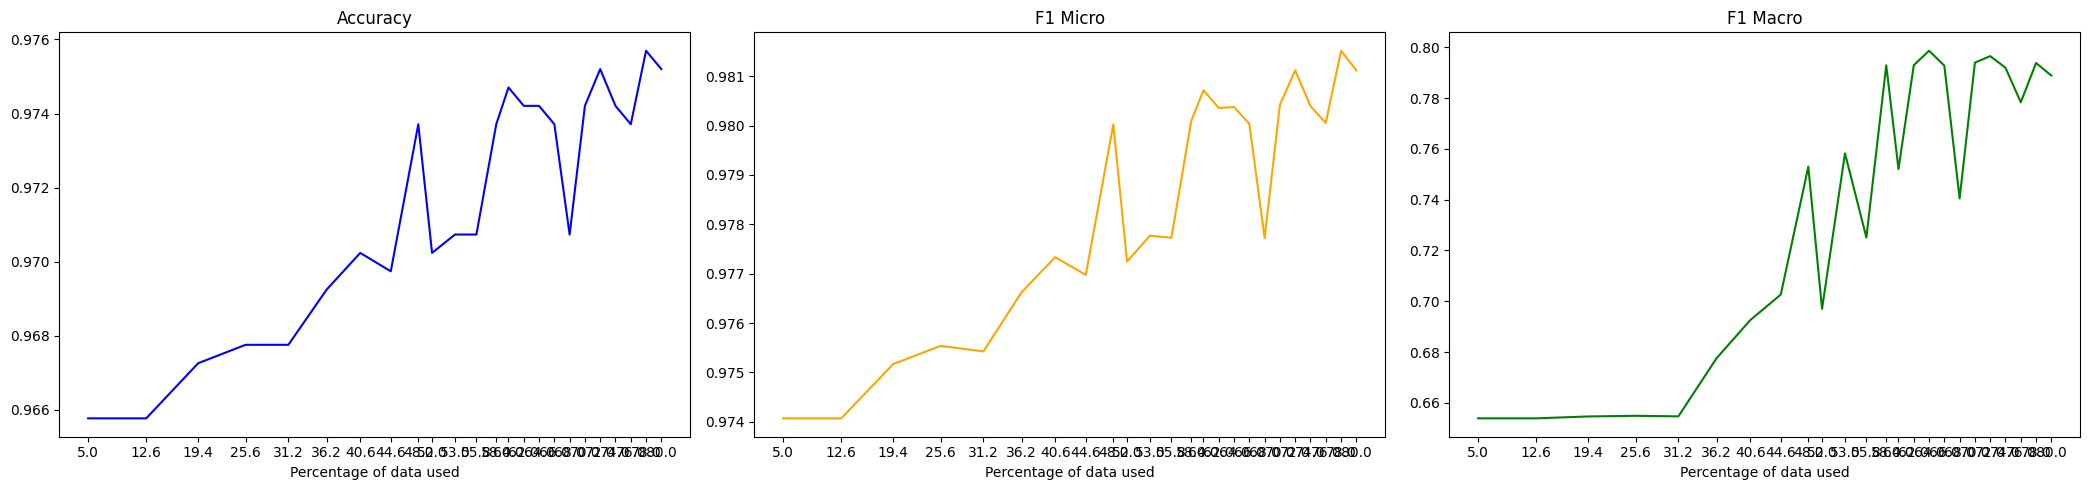

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6126, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4357, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3375, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2449, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2302, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1839, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1606,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6621, Accuracy: 0.8661, F1 Micro: 0.9026, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2982, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2528, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2381, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1912, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1809, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1601

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5926, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4277, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3326, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.271, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2403, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2317, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1561, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1589, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1482, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3303, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1598, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1486,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1541, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1449,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2088, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1627,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1336, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1587,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2071, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1746, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1556, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1387, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1431, Accuracy: 0.9658, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4246, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1871, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1352, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1793, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1506, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1756, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1251, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4237, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1641, Accuracy: 0.9628, F1 Micro: 0.9717, F1 Macro: 0.6521
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.6511
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1546, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1595, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1443, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1081, Accuracy: 0.9583, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1535, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1539, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1353, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9643, F1 Micro: 0.9727

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1356, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9613, F1 Micro: 0.9703

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1374, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1315, Accuracy: 0.9658, F1 Micro: 0.974

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3963, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1412, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1294, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.1098, Accuracy: 0.9598, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1425, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1263, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 9/10, Train Loss: 0.1109, Accuracy: 0.9598, F1 Micro: 0.9691, F1 Macro: 0.6497
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.137, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1182, Accuracy: 0.9628, F1 Micro: 0.971

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1624, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1556, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1489, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.1264, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0994, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3503, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1497, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1397, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.9524, F1 Micro: 0.963, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 10/10, Train Loss: 0.088, Accuracy: 0.965

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3595, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2053, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1397, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1216, Accuracy: 0.9613, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.1293, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1182, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.207, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9554, F1 Micro: 0.9658, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1743, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6508
Epoch 8/10, Train Loss: 0.1258, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1146, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1729, Accuracy: 0.9598, F1 Micro: 0.9694, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1245, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1192, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3506, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6979
Epoch 9/10, Train Loss: 0.1017, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.6915
Epoch 10/10, Train Loss: 0.0701, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1559, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.721
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3393, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9613, F1 Micro: 0.9704, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.697
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.331, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.1263, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7666
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.194, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1747, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1469, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1112, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7118
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.719
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1968, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1448, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.1075, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7283
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3079, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1963, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1477, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1301, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9673, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3212, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.131, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1177, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9688, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3418, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1897, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1212, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7108
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.316, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1794, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1619, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1429, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7346
Epoch 9/10, Train Loss: 0.1114, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3346, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.314, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7295
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9613, F1 Micro: 0.971, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.781
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.32, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2015, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9628, F1 Micro: 0.972, F1 Macro: 0.7386
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.338, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.755
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7765
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.304, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1697, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7868
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7569
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7989
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3223, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7987
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9702, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2994, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7978
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.8034
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3341, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1716, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.721
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9613, F1 Micro: 0.97, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7511
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7924
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7513
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3069, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9613, F1 Micro: 0.971, F1 Macro: 0.7339
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9613, F1 Micro: 0.9704, F1 Macro: 0.7828
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3274, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9717, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3054, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1898, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7555
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7384
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9598, F1 Micro: 0.9696, F1 Macro: 0.7422
Epoch 10/10, Train Loss: 0.0582, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2961, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2016, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9747, F1 Micro: 0.98

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3097, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2029, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7894
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2916, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7543
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7793
Epoch 10/10, Train Loss: 0.0561, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3035, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.153, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7793
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.7547
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1912, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0473, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2999, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1881, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2887, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7274
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9494, F1 Micro: 0.9606, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0471, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3074, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9613, F1 Micro: 0.97, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2824, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9702, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2899, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7876
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7942
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9613, F1 Micro: 0.9704, F1 Macro: 0.7821
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3042, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9598, F1 Micro: 0.9696, F1 Macro: 0.729
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0384, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.188, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0544,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2894, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1904, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9613, F1 Micro: 0.97, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2675, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1809, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.8209
Epoch 10/10, Train Loss: 0.044, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2731, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1531, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7894
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9658, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2876, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.7424
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7534
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1549, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9702, F1 Micro: 0.9776, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.8218
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7935
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7459
Epoch 10/10, Train Loss: 0.0432, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.272, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1473, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7606
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7942
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0365, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1482, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.791
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.7565
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.

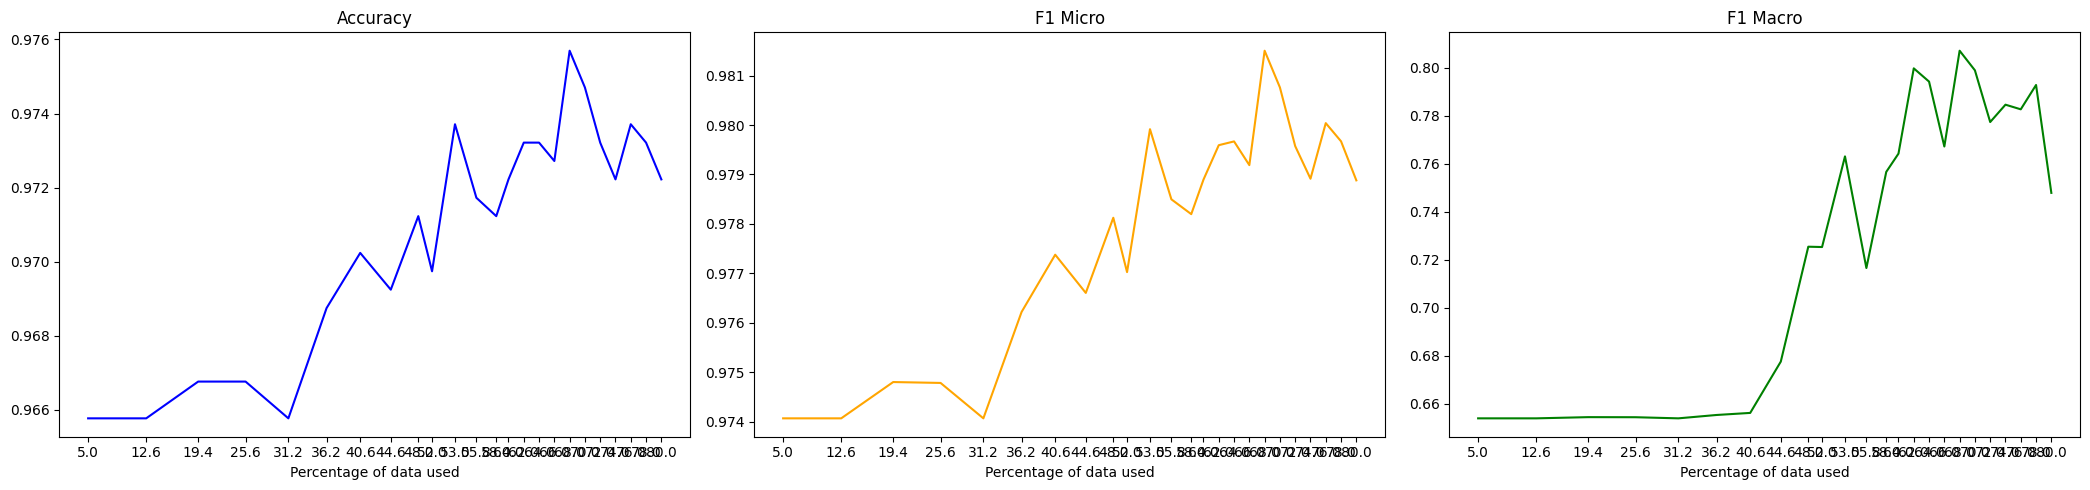

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6719, Accuracy: 0.9613, F1 Micro: 0.9708, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.463, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3423, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2807, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2271, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1838, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1666, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1537, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6567, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3456, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2812, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2195, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1801, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.156, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6631, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2945, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2409, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2408, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2023, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1708,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3087, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.229, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1578, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1467, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1575, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1505, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.187, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1689, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1551, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1602, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1453, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1387, Accuracy: 0.9643, F1 Micro: 0.972

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1503, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.15, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1436, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 9/10, Train Loss: 0.1303, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6493
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1489, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1537, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1549, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1406,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4536, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1634, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1406, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.1394, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Epoch 9/10, Train Loss: 0.1336, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2203, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1637, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1432, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 8/10, Train Loss: 0.1418, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.6522
Epoch 9/10, Train Loss: 0.1335, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 10/10, Train Loss: 0.1076, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4544, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1951, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1482, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1463,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1429, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1334, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1223, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1411, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1457, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6496
Epoch 8/10, Train Loss: 0.1349, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.6512
Epoch 9/10, Train Loss: 0.1165, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 10/10, Train Loss: 0.0936, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1421, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1294, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2045, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1406, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1499, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1231, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.1177, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2022, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1461, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1511, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.12, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6476
Epoch 9/10, Train Loss: 0.1101, Accuracy: 0.9598, F1 Micro: 0.9691, F1 Macro: 0.6498
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1606, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1271, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1233, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2018, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1616, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 8/10, Train Loss: 0.1295, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.1184, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1604, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 7/10, Train Loss: 0.1569, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.1256, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.111, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 10/10, Train Loss: 0.0939, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1827, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1667, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1561, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1291, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.1149, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.351, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1286, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1334, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1115, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3472, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1093, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2113, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1697, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1341, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1167, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1489, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6545
Epoch 10/10, Train Loss: 0.0723, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1569, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1497, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1446, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6527
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6527
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.7191
Epoch 10/10, Train Loss: 0.0741, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2016, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6922
Epoch 10/10, Train Loss: 0.0819, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3357, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1366, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.9673, F1 Micro: 0.9749

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.336, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3458, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1507, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1408, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1194, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.147, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1364, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7066
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3192, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1509, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.1387, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0878, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7031
Epoch 10/10, Train Loss: 0.0686, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3388, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6552
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3492, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.0908, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3466, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7301
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7173
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1963, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 8/10, Train Loss: 0.1188, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.6838
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 10/10, Train Loss: 0.0818, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3282, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1855, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7294
Epoch 10/10, Train Loss: 0.0609, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3278, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1189, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7054
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.1216, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6894
Epoch 10/10, Train Loss: 0.0662, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.322, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1417, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7046
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9598, F1 Micro: 0.9694, F1 Macro: 0.7129
Epoch 10/10, Train Loss: 0.0564, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1497, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1407, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7781
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3264, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1504, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.1171, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0905, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7234
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3217, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2023, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9628, F1 Micro: 0.972, F1 Macro: 0.7434
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9628, F1 Micro: 0.9717, F1 Macro: 0.7434
Epoch 10/10, Train Loss: 0.0493, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2041, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.1248, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7932
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7469
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.654
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1697, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9747, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3233, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1767, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1404, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9539, F1 Micro: 0.9642, F1 Macro: 0.7547
Epoch 10/10, Train Loss: 0.0651, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3361, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1689, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1394, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6576
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7669
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3109, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1948, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9539, F1 Micro: 0.964, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.744
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3117, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1957, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.933, F1 Micro: 0.947, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7975
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9598, F1 Micro: 0.9691, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3208, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7969
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9732, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2991, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.7133
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 10/10, Train Loss: 0.0559, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1534, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6576
Epoch 10/10, Train Loss: 0.0542, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3037, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3048, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9747, F1 Micro: 0.9809, F1 Macro: 0.7903
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3143, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9747, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2955, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9643, F1 Micro: 0.9724, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7442
Epoch 10/10, Train Loss: 0.0463, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0.9643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3046, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7478
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2879, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 10/10, Train Loss: 0.0456, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1861, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2981, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7045
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.279, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1872, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7585
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1879, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2913, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1916, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9717, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1916, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1203, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7974
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0361, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1916, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.289, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1951, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.6539
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0498, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.744
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7895
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7567
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.299, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7797
Higher F1 ac

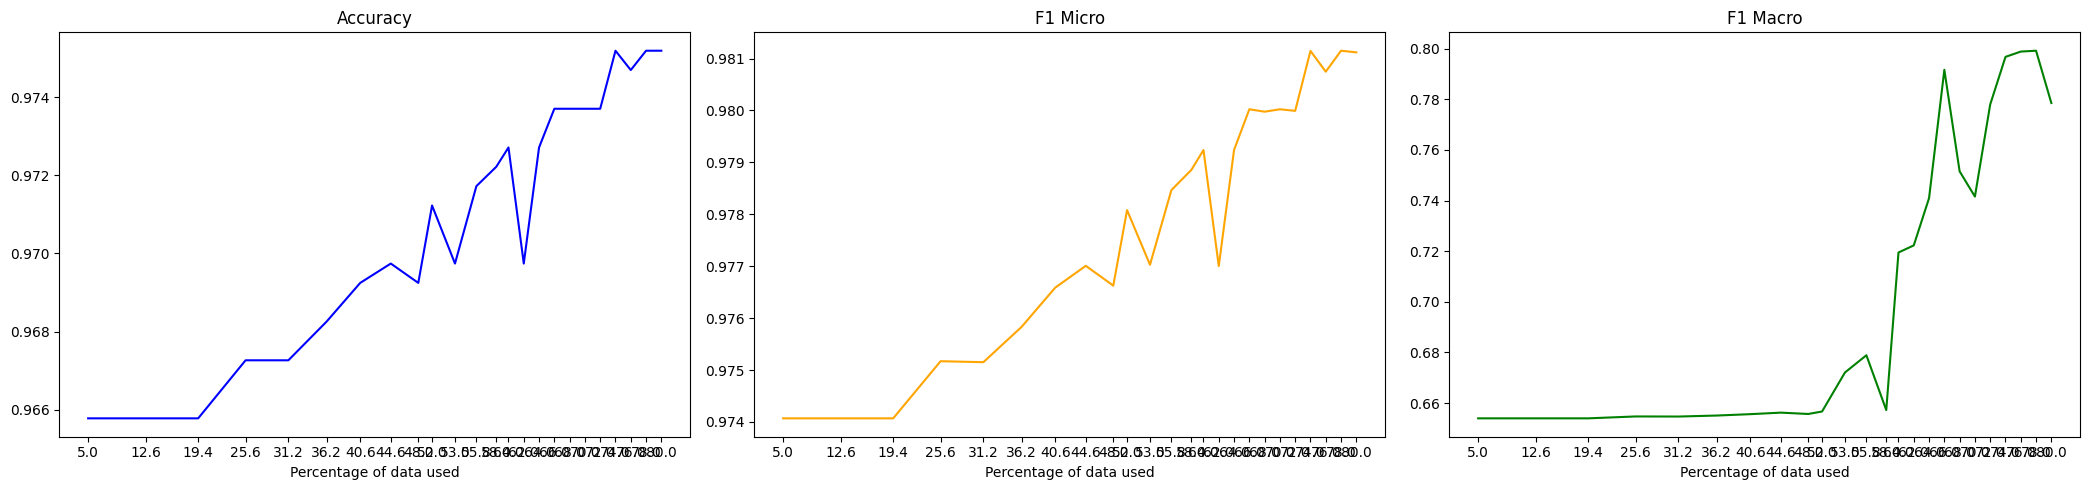

In [ ]:
active_learning(seeds[4], 4)